In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from ta.trend import SMAIndicator

class Common_Class():

    def __init__(self, ticker_list, benchmark, start, end, interval, capital, transcation_cost, allocation_method, verbose = True):
        self.ticker_list = ticker_list
        self.benchmark = benchmark
        self.start = start
        self.end = end
        self.interval = interval
        self.total_initial_capital = capital # this is the initial capital you want to trade with (Portfolio total capital)
        self.stock_initial_capital = self.capital_allocation_for_each_stock(allocation_method) # inital capital for each stock
        self.stock_capital = self.capital_allocation_for_each_stock(allocation_method) # this capital will change depending on the trade
        # self.capital = capital # this capital will change depending on trades
        self.transaction_cost = transcation_cost # the transaction cost for trading
        self.total_transaction_cost = 0
        self.quantity = self.init_quantity() # quantities of stock to buy/sell
        self.position = self.init_position() # the trades in progress, long or short
        self.trade_count = self.init_trade_count() # Number of trades
        self.portfolio_df = pd.DataFrame()
        self.benchmark_df = None
        self.verbose = verbose # if you want to see detailed output (logs)
        self.prepare_data() # prepares the data

    def capital_allocation_for_each_stock(self, allocation_method):
        stocks_capital = {}
        if allocation_method == 'equal':
            for ticker in self.ticker_list:
                stocks_capital[ticker] = self.total_initial_capital / len(self.ticker_list)
        return stocks_capital

    def init_quantity(self):
        quantity = {}
        for ticker in self.ticker_list:
            quantity[ticker] = 0
        return quantity

    def init_position(self):
        position = {}
        for ticker in self.ticker_list:
            position[ticker] = 0
        return position

    def init_trade_count(self):
        trade_count = {}
        for ticker in self.ticker_list:
            trade_count[ticker] = 0
        return trade_count

    def prepare_data(self):
        # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
        # we will calculate the returns though.
        # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.
        self.data = {}
        # Get the data for all the tickers
        for ticker in self.ticker_list:
            stock_data = yf.Ticker(ticker)
            hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
            bt_data = pd.DataFrame()
            bt_data["Close_Price"] = hist_stock["Close"]
            bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
            bt_data = bt_data.dropna()
            self.data[ticker] = bt_data

        # Get the data for the benchmark
            benchmark_data = yf.Ticker(self.benchmark)
            hist_benchmark = benchmark_data.history(start = self.start, end = self.end, interval = self.interval)
            bt_data = pd.DataFrame()
            bt_data["Close_Price"] = hist_benchmark["Close"]
            bt_data["Benchmark Returns"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
            bt_data = bt_data.dropna()
            self.benchmark_df = bt_data


    def close_graph(self, ticker):
        plt.figure(figsize=(15, 5))
        plt.plot(self.data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Close Prices of {}".format(ticker))
        plt.legend()
        plt.grid()
        plt.show()

    def return_date_price(self, ticker, bar):
        # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
        # Since we have modeled close prices, we will get the price and date
        date = str(self.data[ticker].index[bar])[:10]
        price = self.data[ticker].Close_Price.iloc[bar]
        return date, price

    def realised_balance(self, ticker, bar, verbose=True):
        #Returns you the realised capital in your account at a given time period / bar
        date, price = self.return_date_price(ticker, bar)
        if verbose:
            print("Date :{} | Realised Balance: {:0.2f}".format(date,self.stock_capital[ticker]))
        return self.stock_capital[ticker]

    def unrealised_balance(self, ticker, bar, verbose=True):
        #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
        date, price = self.return_date_price(ticker, bar)
        ub = self.quantity[ticker] *price
        if verbose:
            print("Date :{} | Unrealised Balance: {:0.2f}".format(date,ub))
        return ub

    def total_balance(self, ticker, bar, verbose=True):
        #Unrealised plus realised
        date, price = self.return_date_price(ticker, bar)
        tb = self.quantity[ticker] *price + self.stock_capital[ticker]
        if verbose:
            print("Date :{} | Total Balance: {:0.2f}".format(date,tb))
        return tb

    def buy_order(self, ticker, bar,quantity=None, dollar=None ):
        date, price = self.return_date_price(ticker, bar)
        if quantity == None:
            quantity = int(dollar/price)
        self.stock_capital[ticker] = self.stock_capital[ticker] - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
        self.quantity[ticker] = self.quantity[ticker] + quantity
        self.trade_count[ticker] = self.trade_count[ticker] + 1
        self.total_transaction_cost += self.transaction_cost * (quantity * price)
        if self.verbose:
            print("Bought {} shares of {} at {:0.2f} per share worth {:0.2f} $".format(quantity, ticker, price, quantity * price))
            self.realised_balance(ticker, bar)
            self.unrealised_balance(ticker, bar)
            self.total_balance(ticker, bar)

    def sell_order(self,ticker, bar,quantity=None, dollar=None ):
        date, price = self.return_date_price(ticker, bar)
        if quantity == None:
            quantity = int(dollar/price)
        self.stock_capital[ticker] = self.stock_capital[ticker] + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
        self.quantity[ticker] = self.quantity[ticker] - quantity
        self.trade_count[ticker] = self.trade_count[ticker] + 1
        self.total_transaction_cost += self.transaction_cost * (quantity * price)
        if self.verbose:
            print("Sold {} shares of {} at {:0.2f} per share worth {:0.2f} $".format(quantity,ticker, price, quantity * price))
            self.realised_balance(ticker, bar)
            self.unrealised_balance(ticker, bar)
            self.total_balance(ticker, bar)

    def daily_portfolio_information(self, bar):
        portfolio_tb = 0
        portfolio_ub = 0
        portfolio_rb = 0
        for ticker in self.ticker_list:
            portfolio_rb += self.realised_balance(ticker, bar, verbose=False)
            portfolio_ub += self.unrealised_balance(ticker, bar, verbose=False)
            portfolio_tb += self.total_balance(ticker, bar, verbose=False)

        date, price = self.return_date_price(ticker, bar)
        self.portfolio_df.loc[date, ['portfolio_tb', 'portfolio_ub', 'portfolio_rb',]] = portfolio_tb, portfolio_ub, portfolio_rb,

    # Close any open position at the end of the backtesting
    def last_trade(self, ticker, bar):
        date, price = self.return_date_price(ticker, bar)
        last_quantity = self.quantity[ticker]
        self.stock_capital[ticker] = self.stock_capital[ticker] + self.quantity[ticker] * price
        self.quantity[ticker] = 0 # as no more quantity now. all will be settled
        self.trade_count[ticker] = self.trade_count[ticker] + 1
        if self.verbose:
            print("Closed open trades for {} shares of {} at {:0.2f} per share worth {:0.2f} $"\
                        .format(last_quantity,ticker, price, last_quantity * price))
            self.total_balance(ticker, bar)

            returns = (self.stock_capital[ticker] - self.stock_initial_capital[ticker]) / self.stock_initial_capital[ticker] * 100
            print("The total capital at end of strategy for {}: {:0.2f}".format(ticker, self.stock_capital[ticker]))
            print( "The strategy returns on investment are {:0.2f} %".format(returns))
            print( "Total trades by strategy for {}: {:0.2f}".format(ticker, self.trade_count[ticker]))

            self.daily_portfolio_information(bar)

            # Add inital total capital to the portfolio df
            self.portfolio_df.index = pd.to_datetime(self.portfolio_df.index)
            self.portfolio_df['portfolio_daily_returns'] = np.log(self.portfolio_df['portfolio_tb'] / self.portfolio_df['portfolio_tb'].shift(1))
            self.portfolio_df.iloc[0, self.portfolio_df.columns.get_loc('portfolio_daily_returns')] = np.log(self.portfolio_df.iloc[0, self.portfolio_df.columns.get_loc('portfolio_tb')]  / self.total_initial_capital)

    def calculate_portfolio_statistics(self):
        total_trade_count = 0
        for trade_count in self.trade_count.values():
            total_trade_count += trade_count

        total_final_capital = 0
        for capital in self.stock_capital.values():
            total_final_capital += capital

        portfolio_log_returns = self.portfolio_df['portfolio_daily_returns'].sum() * 100
        portfolio_normal_returns = (total_final_capital - self.total_initial_capital) / self.total_initial_capital * 100
        portfolio_annual_mean_returns = np.exp(self.portfolio_df['portfolio_daily_returns'].mean() * 252) - 1
        portfolio_annual_regular_std = (np.exp(self.portfolio_df['portfolio_daily_returns']) -1).std() * (252 ** 0.5)
        portfolio_annual_sharpe_ratio = portfolio_annual_mean_returns / portfolio_annual_regular_std

        # Add benchmark returns
        self.benchmark_df.index = pd.to_datetime(self.benchmark_df.index.date)
        self.portfolio_df = self.portfolio_df.merge(self.benchmark_df[['Benchmark Returns']], how='left', left_index=True, right_index=True)
        benchmark_annual_regular_returns = np.exp(self.portfolio_df['Benchmark Returns'].mean() * 252) -1

        # Beta
        matrix = self.portfolio_df[['portfolio_daily_returns', 'Benchmark Returns']].cov()
        beta = matrix.iat[0, 1] / matrix.iat[1, 1]

        # Portfolio information ratio
        self.portfolio_df['portfolio-benchmark'] = self.portfolio_df['portfolio_daily_returns'] - self.portfolio_df['Benchmark Returns']
        average_of_difference = self.portfolio_df['portfolio-benchmark'].mean()
        std_of_difference = self.portfolio_df['portfolio-benchmark'].std()
        daily_ir = average_of_difference / std_of_difference
        annual_ir = daily_ir * (252 ** 0.5)

        # Treynor ratio
        portfolio_treynor_ratio = portfolio_annual_mean_returns / beta

        # Max drawdown
        self.portfolio_df['portfolio_gross_cum_returns'] = self.portfolio_df['portfolio_daily_returns'].cumsum().apply(np.exp)
        self.portfolio_df['portfolio_gross_cum_max_returns'] = self.portfolio_df['portfolio_gross_cum_returns'].cummax()
        max_drawdown = (self.portfolio_df['portfolio_gross_cum_max_returns'] - self.portfolio_df['portfolio_gross_cum_returns']).max()

        # Calmar ratio
        portfolio_calmar_ratio = portfolio_annual_mean_returns / max_drawdown

        # Sortino ratio
        portfolio_negative_returns_df = self.portfolio_df[self.portfolio_df['portfolio_daily_returns'] < 0]
        annual_negative_portfolio_std = (np.exp(portfolio_negative_returns_df['portfolio_daily_returns']) - 1).std() * (252 ** 0.5)
        portfolio_sortino_ratio = portfolio_annual_mean_returns / annual_negative_portfolio_std



        print("Total trade count {} ".format(total_trade_count))
        print("Total transaction cost: {:0.2f} $".format(self.total_transaction_cost))
        print("Starting capital: {}".format(self.total_initial_capital))
        print("Final capital: {:0.2f}".format(total_final_capital))
        print('Log Portfolio returns: {:0.2f} %'.format(portfolio_log_returns))
        print("Normal Portfolio returns: {:0.2f} %".format(portfolio_normal_returns))
        print('Portfolio Annual Mean returns: {:0.2f}'.format(portfolio_annual_mean_returns))
        print('Portfolio Annual Regular std: {:0.2f}'.format(portfolio_annual_regular_std))
        print('Portfolio Annual Sharpe Ratio: {:0.2f}'.format(portfolio_annual_sharpe_ratio))
        print('{} Benchmark Annual Mean returns: {:0.2f}'.format(self.benchmark, benchmark_annual_regular_returns))
        print('Annual Information Ratio: {:0.2f}'.format(annual_ir))
        print('Portfolio Treynor Ratio: {:0.2f}'.format(portfolio_treynor_ratio))
        print('Portfolio Calmar Ratio: {:0.2f}'.format(portfolio_calmar_ratio))
        print('Portfolio Sortino Ratio: {:0.2f}'.format(portfolio_sortino_ratio))

    def visualise_portfolio_performance(self):
            fig, ax = plt.subplots(2, 2, figsize=(15, 8))

            ax[0][0].plot(self.portfolio_df['portfolio_daily_returns'].cumsum())
            ax[0][0].set_title('Portfolio Returns')

            ax[0][1].plot(self.portfolio_df['portfolio_tb'])
            ax[0][1].set_title('Portfolio Total Balance')

            ax[1][0].plot(self.portfolio_df['portfolio_rb'])
            ax[1][0].set_title('Portfolio Realised Balance')

            ax[1][1].plot(self.portfolio_df['portfolio_ub'])
            ax[1][1].set_title('Portfolio Unrealised Balance')

            fig.tight_layout()


class MA_Strategy(Common_Class):

    def go_long(self, ticker, bar, quantity = None, dollar = None):
        if self.position[ticker] == -1:
            self.buy_order(ticker, bar, quantity = -self.quantity[ticker]) #to clear previous short position and therefore negative quantity.
        if quantity:
            self.buy_order (ticker, bar, quantity = quantity) # to create new fresh order
        elif dollar:
            if dollar == 'all':
                dollar = self.stock_capital[ticker]
                self.buy_order(ticker, bar, dollar = dollar)

    def go_short(self, ticker, bar, quantity = None, dollar = None):
        if self.position[ticker] == 1:
            self.sell_order(ticker, bar, quantity = self.quantity[ticker]) # to clear previous long vposition
        if quantity:
            self.sell_order(ticker, bar, quantity = quantity) # to create new fresh order
        elif dollar:
            if dollar == 'all':
                dollar = self.stock_capital[ticker]
                self.sell_order(ticker, bar, dollar = dollar)


    def visualise_strategy(self, ticker, STMA_window, LTMA_window, axs):
            axs.plot(self.data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
            axs.plot(self.data[ticker]["STMA"], color='b', label='Short term MA')
            axs.plot(self.data[ticker]["LTMA"], color='r', label='Long term MA')
            axs.plot(self.data[ticker][self.data[ticker]['Signal'] == 2].index,
                        self.data[ticker]['STMA'][self.data[ticker]['Signal'] == 2],
                        '^', markersize = 15, color = 'g', label = 'buy/long')
            axs.plot(self.data[ticker][self.data[ticker]['Signal'] == -2].index,
                        self.data[ticker]['STMA'][self.data[ticker]['Signal'] == -2],
                        'v', markersize = 15, color = 'r', label = 'sell/short')

            axs.set_xlabel("Days")
            axs.set_ylabel("Price")
            axs.set_title("Moving Averages Crossover {} Vs {} for {}".format(STMA_window, LTMA_window, ticker))
            axs.legend()
            plt.grid()

    def visualise_position(self, ticker, axs):
            axs.plot(self.data[ticker]["Position"])
            axs.set_title("Long/Short status for {}".format(ticker))
            axs.grid()

    def visualise_stock_returns_distribution(self, ticker, axs):
            axs.hist(self.data[ticker]["Strategy_Returns"], bins = 40, label='Strategy Returns', alpha=0.5)
            axs.hist(self.data[ticker]["Stock_Returns"], bins = 40, label='Stock Returns', alpha=0.5)
            axs.set_title("Histogram of Stock Daily Log Returns for {}".format(ticker))
            axs.legend()
            axs.grid()

    def visualise_stock_and_strategy_returns(self, ticker, axs):
            axs.plot(self.data[ticker][["Strategy_Returns"]].cumsum(), label='Strategy_Returns')
            axs.plot(self.data[ticker][["Stock_Returns"]].cumsum(), label='Stock_Returns')
            axs.legend()
            axs.set_title('Stock vs Strategy Returns for {}'.format(ticker))
            axs.grid()

    def run_strategy(self, STMA_window, LTMA_window):
            for ticker in self.data.keys():
                # Get indicators for all the tickers
                indicator_1 = SMAIndicator(close = self.data[ticker]["Close_Price"], window = STMA_window, fillna= False)
                STMA = indicator_1.sma_indicator()
                indicator_2 = SMAIndicator(close = self.data[ticker]["Close_Price"], window = LTMA_window, fillna= False)
                LTMA = indicator_2.sma_indicator()
                self.data[ticker]["STMA"] = STMA
                self.data[ticker]["LTMA"] = LTMA

            for bar in range(LTMA_window, len(self.data[self.ticker_list[0]])):
                for ticker in self.ticker_list:
                    if self.position[ticker] in [0,-1]: # checking no position or short position
                        if self.data[ticker]["STMA"].iloc[bar]>self.data[ticker]["LTMA"].iloc[bar]:
                            self.go_long(ticker, bar, dollar="all") # go with all money
                            self.position[ticker] = 1 # long created
                            print("-------------------")

                    if self.position[ticker] in [0,1]: # checking no position or long position
                        if self.data[ticker]["STMA"].iloc[bar]<self.data[ticker]["LTMA"].iloc[bar]:
                            self.go_short(ticker, bar, dollar ="all") # go with all money
                            self.position[ticker] = -1 # short created
                            print("---------------------")

                # Get the daily portfolio total balance, unrealised balance and realised balance
                self.daily_portfolio_information(bar)

            # Last trade
            for ticker in self.ticker_list:
                print("-----------------------------------")
                self.last_trade(ticker, bar)

            print("-----------------------------------")
            print("---------- Portfolio statistics ----------")
            self.calculate_portfolio_statistics()


            print(self.portfolio_df.head(20))


            # Visualise portfolio performance
            self.visualise_portfolio_performance()

            # Visualisation strategy for each ticker
            for ticker in self.data.keys():
                # Add position and signal column to the data
                self.data[ticker]['Position'] = np.where(self.data[ticker]['STMA'] > self.data[ticker]['LTMA'], 1.0, -1.0)
                self.data[ticker]['Signal'] = self.data[ticker]['Position'].diff()
                # Add stock returns
                self.data[ticker]['Stock_Returns'] = np.log(self.data[ticker]["Close_Price"] / self.data[ticker]["Close_Price"].shift(1))
                # Add strategy returns
                self.data[ticker]["Strategy_Returns"] = self.data[ticker]["Stock_Returns"] * self.data[ticker]["Position"].shift(1)

                # Visualtions
                fig, ax = plt.subplots(2, 2, figsize=(15, 8))
                self.visualise_strategy(ticker, STMA_window, LTMA_window, axs=ax[0][0])
                self.visualise_position(ticker, axs=ax[0][1])
                self.visualise_stock_and_strategy_returns(ticker, axs=ax[1][0])
                self.visualise_stock_returns_distribution(ticker, axs=ax[1][1])
                fig.tight_layout()
                plt.show()


Bought 960 shares of AAPL at 10.41 per share worth 9994.22 $
Date :2011-01-25 | Realised Balance: -94.17
Date :2011-01-25 | Unrealised Balance: 9994.22
Date :2011-01-25 | Total Balance: 9900.06
-------------------
Bought 647 shares of GOOG at 15.44 per share worth 9989.60 $
Date :2011-01-25 | Realised Balance: -89.50
Date :2011-01-25 | Unrealised Balance: 9989.60
Date :2011-01-25 | Total Balance: 9900.10
-------------------
Bought 374 shares of NFLX at 26.68 per share worth 9977.25 $
Date :2011-01-25 | Realised Balance: -77.02
Date :2011-01-25 | Unrealised Balance: 9977.25
Date :2011-01-25 | Total Balance: 9900.23
-------------------
Bought 1131 shares of AMZN at 8.84 per share worth 9992.39 $
Date :2011-01-25 | Realised Balance: -92.31
Date :2011-01-25 | Unrealised Balance: 9992.39
Date :2011-01-25 | Total Balance: 9900.08
-------------------
Sold 647 shares of GOOG at 13.34 per share worth 8628.56 $
Date :2011-05-11 | Realised Balance: 8452.78
Date :2011-05-11 | Unrealised Balance: 0

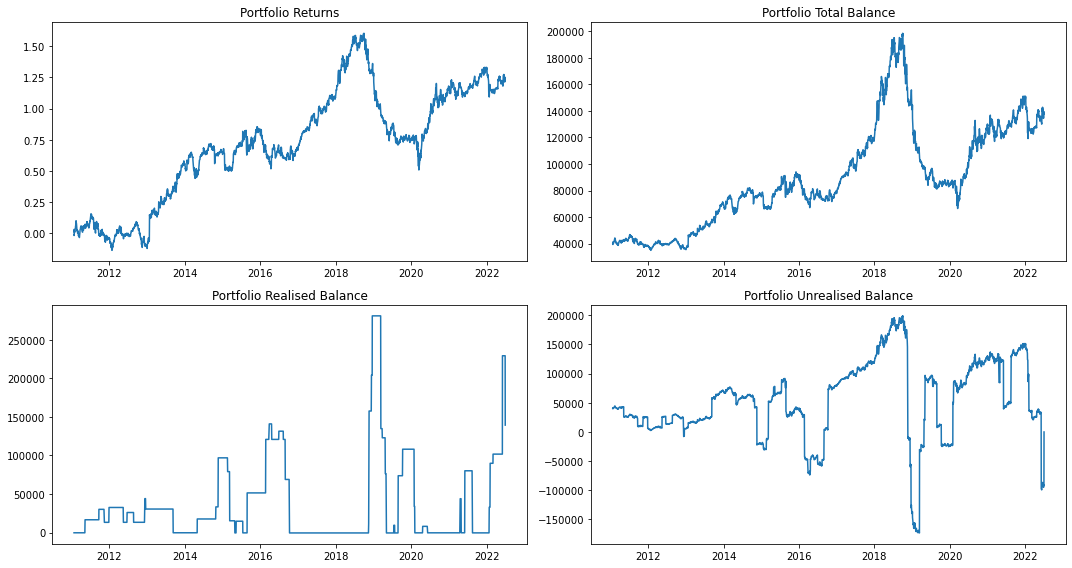

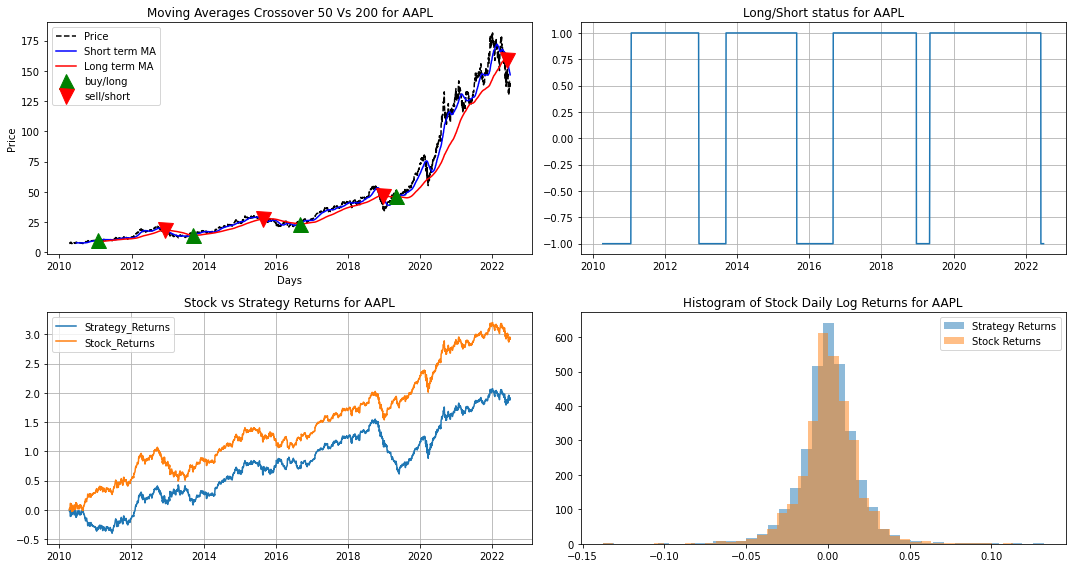

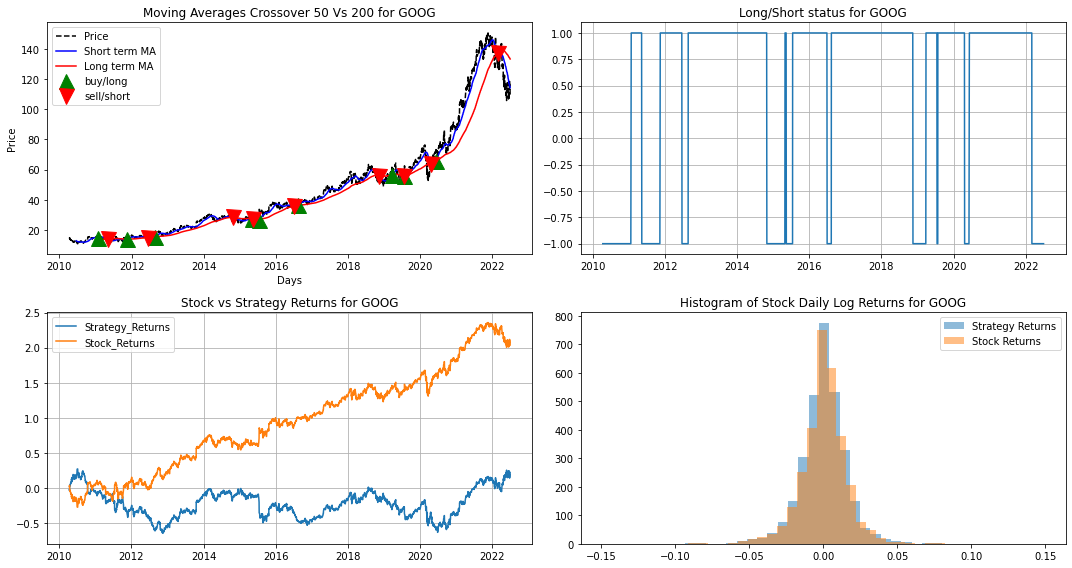

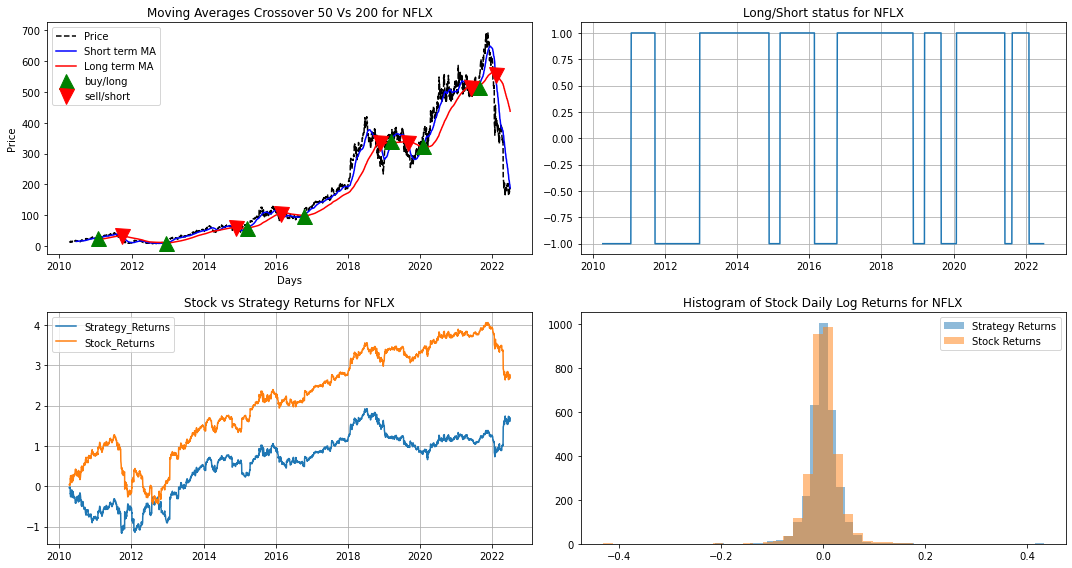

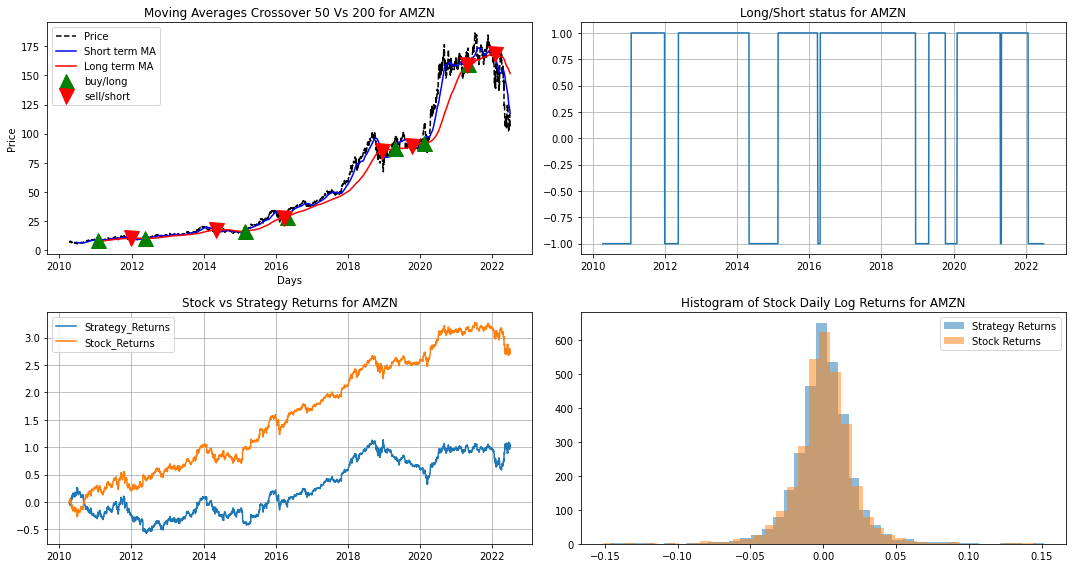

In [5]:
# configurations
tickers = ["AAPL", "GOOG", "NFLX", "AMZN",] # META excluded because META IPO on 2012, data setsize is different
total_capital = 40000
# strategy for multiple stocks, assuming capital allocation for each stock is equal
A = MA_Strategy(ticker_list=tickers,
                                benchmark='^GSPC',
                                start="2010-04-10",
                                end="2022-07-01",
                                interval="1d",
                                capital=total_capital,
                                transcation_cost=0.01,
                                allocation_method='equal',
                                verbose =True)
# Run strategy
A.run_strategy(50,200)